# Production-Destruction


## Model description

A production-destruction system consists of an ordinary differential equation and two constraints:
positivity and conservativity. It means that the system states are quantities which are always positive
and the sum of these quantities is constant. This particular family of systems is often used to test
the stability of integration schemes.

As proposed by **Michaelis-Menten** theory [^KM18], a model for three quantities can be defined as follows:

$$
   \left\{ \begin{array}{lcl}
   \dot{x} &=& \dfrac{-xy}{1+x}\\ \\
   \dot{y} &=& \dfrac{xy}{1+x} - a y\\ \\
   \dot{z} &=& ay
   \end{array} \right.
$$
with nominal values ``a = 0.3`` and an initial condition ```x(0) = 9.98``, ``y(0) = 0.01`` and
``z(0) = 0.01``. In this model, ``x`` is the nutrients, ``y`` the phytoplankton
and ``z`` the detritus. In this notebook we analyze the behavior of the system
subject to uncertainties in the initial condition and/or the model's parameter `a`
using forward reachability analysis.

The solution should satisfy the following two constraints:

- **Positivity:** ``x(t)``, ``y(t)``, ``z(t)`` are positive, and
- **Conservativity:** ``x(t) + y(t) + z(t) = 10`` for all ``t \ge 0``.

In this notebook we are interested in computing the reachable tube until the time horizon ``T=100``,
and to verify (or embed) the  constraints. Three setups are considered, depending on the source
of bounded uncertainties which is taken into account:

- **Case I**: ``x(0) \in [9.5, 10.0]``, i.e., uncertainty on the initial condition;
- **Case P**: ``a \in [0.296, 0.304]``, i.e., uncertainty on the parameter;
- **Case I & P**: ``x(0) \in [9.5, 10.0]`` and ``a \in [0.296, 0.304]``, i.e., both uncertainties are mixed.

In terms of objectives, at ``T = 100``, the constraints ``10 \in x+y+z`` and
``x, y, z \geq 0`` have to be verified.

The reachability settings considered above are a variation of those in [^ARCHCOMP20_NLN].
Please note that variables $x$ and $y$ converge towards zero, so the final volume can be used
as a quality measure of the overapproximation.

In the next section we explain how to check whether the constraints are satisfied
using `LazySets.jl`.

## Checking satisfiability with sets

Two measures of quality of the approximation are considered: the volume of the box
(``x \times y \times z``) enclosing the final state (at ``T = 100``) and the total
time of computation for evolution and verification.
All of these results are obtained for the three setups.

Let us discuss the implementation of each constraint satisfaction problem.
We begin by defining the positive orthant in three-dimensional space,
`positive_orthant`, as an unbounded polyhedron in constraint representation.

In [1]:
using ReachabilityAnalysis, Symbolics, Plots

@variables x y z
const positive_orthant = HPolyhedron([x >= 0, y >= 0, z >= 0], [x, y, z])

HPolyhedron{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, -1.0], 0.0)])

Given a set $X \subseteq \mathbb{R}^n$, to check whether the positivity constraint
holds correspnods to checking wheter ``X`` is included in the positive orthant.
This computation can be done efficiently using support functions, and it is available
in `LazySets.jl`. Multiple dispatch takes care based on the types of the arguments
in the call `X ⊆ positive_orthant` depending on the type of ``X``.

On the other hand, given a set ``X``, a quick way to check the conservativity constraint
is to first overapproximate ``X`` with a box, then represent such box as a
product-of-intervals (`IntervalBox`) `B`, and finally take the Minkowski
sum of each line segment, using `sum(B)`. This check is only sufficient; splitting
``X`` can be used to refine the check.

The verification problem is summarized in the function `prod_dest_verif`.
It receives the solution of a reachability problem represented with
a Taylor model flowpipe and two optional arguments that specify the time horizon
`T` and the conservativity condition given a target state `target`,
which defaults to `10`. The function returns the tuple `(flag, vol)` where `flag`
is true if and only if the positivity and conservativity conditions are satisfied at the time horizon
`T`, which defaults to `100`. The second output, `vol`, corresponds to the volume
of the box overapproximation of the final reach-set.

In [2]:
function prod_dest_verif(sol; T=100.0, target=10.0)

    # convert to a zonotopic flowpipe
    solz = overapproximate(sol, Zonotope)

    # project the final reach-set onto the space variables x, y, z
    X = project(solz(T), vars=(1, 2, 3))

    # check that all variables are nonnegative
    nonnegative = X ⊆ positive_orthant

    # compute the volume of the last reach-set
    H = overapproximate(X, Hyperrectangle)
    vol = volume(H)

    # check that that target belongs to the minkowski sum of the reach-sets projected in each coordinate
    B = convert(IntervalBox, H) # get the product-of-intervals representation
    contains_target = target ∈ sum(B)

    return nonnegative && contains_target, vol
end

prod_dest_verif (generic function with 1 method)

## Case I

Case I corresponds to initial states uncertainty. We begin by writing the system
of ODEs in the function `prod_dest_I!`.

In [3]:
@taylorize function prod_dest_I!(du, u, params, t)
    local a = 0.3
    x, y, z = u[1], u[2], u[3]

    du[1] = - (x * y) / (1 + x)
    du[2] = (x * y) / (1 + x) - a * y
    du[3] = a * y
    return du
end

We define the initial states as the cartesian product of intervals.

In [4]:
X0 = (9.5 .. 10.0) × (0.01 .. 0.01) × (0.01 .. 0.01)
prob = @ivp(x'= prod_dest_I!(x), dim:3, x(0) ∈ X0)

solI = solve(prob, T=100.0, alg=TMJets(abstol=1e-11, orderT=7, orderQ=1));

Verifying that the specification holds:

In [5]:
property, vol = prod_dest_verif(solI)

(false, 5.6891232659242134e-5)

Now we plot ``z`` (in the ``[0, 11]`` range) w.r.t. time (in the ``[0, 100]`` range).

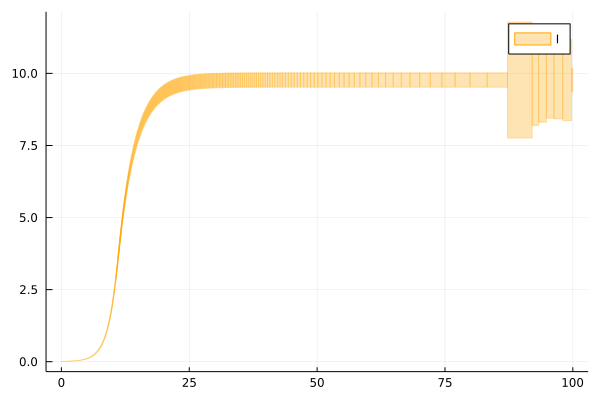

In [6]:
plot(solI, vars=(0, 3), linecolor=:orange, color=:orange, alpha=0.3, lab="I")

## Case P

For the case of an uncertain parameter, we add a new state variable that corresponds
to `a`, with constant (zero) dynamics.

In [7]:
@taylorize function prod_dest_IP!(du, u, params, t)
    x, y, z, a = u[1], u[2], u[3], u[4]

    du[1] = - (x * y) / (1 + x)
    du[2] = (x * y) / (1 + x) - a * y
    du[3] = a * y
    du[4] = zero(x)
    return du
end

X0 = (9.98 .. 9.98) × (0.01 .. 0.01) × (0.01 .. 0.01) × (0.296 .. 0.304)
prob = @ivp(x'= prod_dest_IP!(x), dim:4, x(0) ∈ X0)

solP = solve(prob, T=100.0, alg=TMJets(abstol=1e-12, orderT=7, orderQ=1));

Verifying that the specification holds:

In [8]:
property, vol = prod_dest_verif(solP)

(false, 6.413444562237618e-10)

Now we plot ``z`` (in the ``[0, 11]`` range) w.r.t. time (in the ``[0, 100]`` range).

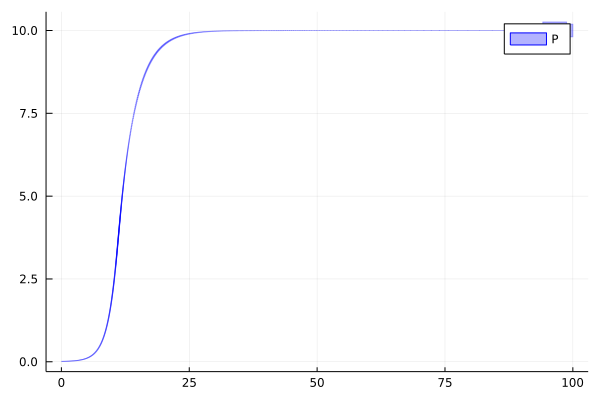

In [9]:
plot(solP, vars=(0, 3), linecolor=:blue, color=:blue, alpha=0.3, lab="P")

## Case I & P

When uncertainty in both the intial states and the paramters are present, we can
reuse the function `prod_dest_IP!`, but setting an uncertain initial condition
and an uncertain parameter.
Recall that we are interested in ``x(0) \in [9.5, 10.0]`` and ``a \in [0.296, 0.304]``.

In [10]:
X0 = (9.5 .. 10.0) × (0.01 .. 0.01) × (0.01 .. 0.01) × (0.296 .. 0.304)
prob = @ivp(x'= prod_dest_IP!(x), dim:4, x(0) ∈ X0)

solIP = solve(prob, T=100.0, alg=TMJets(abstol=1e-11, orderT=7, orderQ=1));

Verifying that the specification holds:

In [11]:
property, vol = prod_dest_verif(solIP)

(false, 0.48925336402228553)

Now we plot ``z`` (in the ``[0, 11]`` range) w.r.t. time (in the ``[0, 100]`` range).

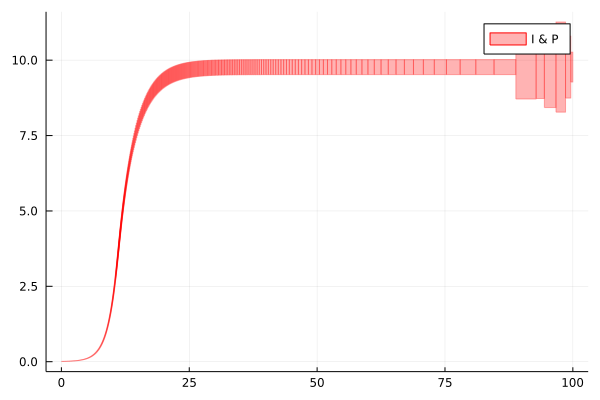

In [12]:
plot(solIP, vars=(0, 3), linecolor=:red, color=:red, alpha=0.3, lab="I & P")

## Performance optimization

We have observed that the specifications are satisfied in all cases. The question remains
if we can tune the problem implementation such that we can verify these properties in less time.
In this section we put into practice the ideas explained in Some common gotchas.
First, consider the function `prod_dest_I!` defined above. The term `du[1] = -x*y / (1+x)`
has the numerator and denominator in common with respect to `du[2]`, so we can store
those values in an auxiliary variable. Similar comments apply to the function
with varying parameter `a`. The final functions are presented below.

In [13]:
@taylorize function prod_dest_I_optimized!(du, u, params, t)
    local a = 0.3
    x, y, z = u[1], u[2], u[3]

    num = x * y
    den = 1 + x
    aux = num/den
    aux2 = a * y
    du[1] = -aux
    du[2] = aux - aux2
    du[3] = aux2
    return du
end

@taylorize function prod_dest_IP_optimized!(du, u, params, t)
    x, y, z, a = u[1], u[2], u[3], u[4]

    num = x * y
    den = 1 + x
    aux = num/den
    aux2 = a * y
    du[1] = -aux
    du[2] = aux - aux2
    du[3] = aux2
    du[4] = zero(x)
    return du
end

With respect to parameter tuning, we have observed that for all three cases
a good parameter choice is ``n_T = 7``, ``n_Q = 1``, and an adaptive absolute
tolerance with initial value ``10^{-11}`` (resp ``10^{-12}``) for ``I``
and ``I`` and ``P`` (resp. ``P``). This choice offers a good balance between runtime
and precision.

## References

[^ARCHCOMP20_NLN]: *ARCH-COMP20 Category Report: Continuous and Hybrid Systems with Nonlinear Dynamics.* Luca Geretti, Julien Alexandre dit Sandretto, Matthias Althoff, Luis Benet, Alexandre Chapoutot, Xin Chen, Pieter Collins, Marcelo Forets, Daniel Freire, Fabian Immler, Niklas Kochdumper, David P. Sanders and Christian Schilling (2020) ARCH20. To appear in 7th International Workshop on Applied Verification of Continuous and Hybrid Systems. 7th International Workshop on Applied Verification of Continuous and Hybrid Systems (ARCH20), vol 74, pages 49--75. 10.29007/zkf6.

[^KM18]: Kopecz, Stefan, and Andreas Meister. *On order conditions for modified Patankar–Runge–Kutta schemes.* Applied Numerical Mathematics 123 (2018): 159-179.